# Description:
This script focusses on fitting the S$\alpha$S distribution to
an ADC count distribution. The main part consists of an exploration of the
S$\alpha$S distribution followed by a manual fit of this distribution to a specific run
of data and a characterisation of the noise for a full station.

# Import modules:

In [25]:
import numpy as np
import scipy as sc
import scipy.fft as scfft
import matplotlib.pyplot as plt
import uproot
import os
import time
#%matplotlib widget

In [26]:
%%capture out
%run ./FunctionsRevised.ipynb

# Fitting the S$\alpha$S function

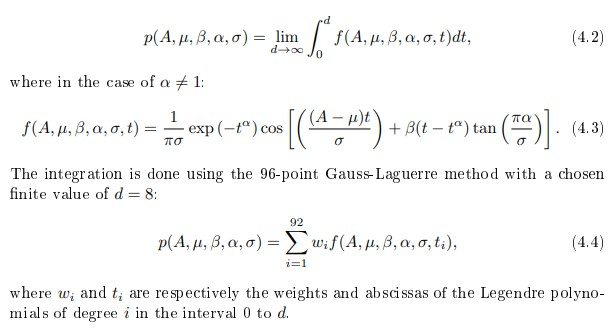

$\mu$ is any real number, $\beta$ in [-1,1], $\alpha$ in [0,2) and $\sigma$ > 0

*Source:Wendy Docters, Unraveling the mysteries of high-energy cosmic rays using radio detection*

follow Gauss-Laguerre method or just basic numeric integration? <br>
 => Gauss-Laguerre method much better computational-wise

Verify that np.polynomial.laguerre.laggauss() works as it should:

In [27]:
np.polynomial.laguerre.laggauss(5)

(array([ 0.26356032,  1.41340306,  3.59642577,  7.08581001, 12.64080084]),
 array([5.21755611e-01, 3.98666811e-01, 7.59424497e-02, 3.61175868e-03,
        2.33699724e-05]))

Visualize both methods:

Time to compute Gaussian Laguerre method:0.6977496147155762
Time to compute brute force integration method:0.4998490810394287
So it went 28.362686198947983% faster


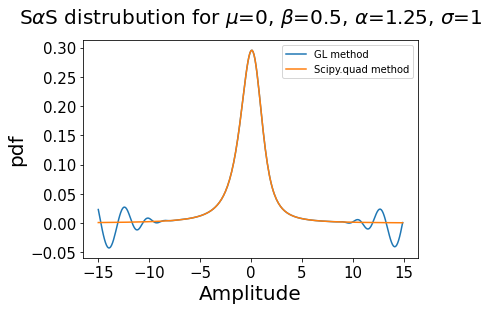

In [29]:
Amplitudes=np.arange(-15,15,0.1)
t0 = time.time()
P_AGL=[SASGL(A,0,0.5,1.25,1) for A in Amplitudes]
t1 = time.time()
P_AQ=[SASQuad(A,0,0.5,1.25,1) for A in Amplitudes]
t2 = time.time()
print("Time to compute Gaussian Laguerre method:" + str(t1-t0))
print("Time to compute brute force integration method:" + str(t2-t1))
print("So it went " + str(100*(2*t1-t0-t2)/(t1-t0)) +"% faster")

plt.figure()#figsize=(20,5))
plt.plot(Amplitudes,P_AGL,'-', label="GL method")
plt.plot(Amplitudes,P_AQ,'-', label="Scipy.quad method")
#plt.plot(Energies,TritonEnergyLoss,'-',color=²'r', label="Triton")
plt.title(r"S$\alpha$S distrubution for $\mu$=" + str(0) + r", $\beta$=" + str(0.5) + r", $\alpha$=" + str(1.25) + r", $\sigma$=" + str(1),fontsize=20, x=0.5, y=1.05)
#plt.ylim(-50,50)
#plt.xlim(0,np.max(SamplingTimes*(10**9)))
plt.xlabel("Amplitude",fontsize=20)
plt.ylabel("pdf",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.yscale("log")
plt.legend()
plt.show()

Which is consistent with the paper *ON THE COMPUTATION OF THE PROBABILITY DENSITY FUNCTION OF α-STABLE DISTRIBUTIONS* by I.A. BELOV



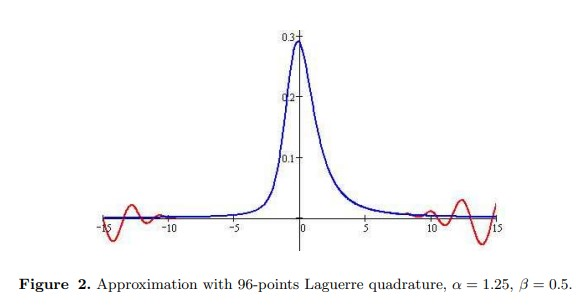

The oscillations might prove problematic. <br>
For now I'll leave them be but they can be rid of by adding an extra integral with a shift in t

Sanity checks (integral of pdf over all amplitudes should give 1 and for A-> inf => pdf -> 0)

QuadNorm=scipy.integrate.quad(SASQuad,-np.inf,np.inf,args=(0,0,1,1))[0]
print(QuadNorm)

GLNorm=scipy.integrate.quad(SASGL,-np.inf,np.inf,args=(0,0,1,1))[0]
print(GLNorm)

In [5]:
SASGL(10**300,0,0,1,1)

0.01699264968207198

In [6]:
SASQuad(10**300,0,0,1,1)

/tmp/ipykernel_617/3954356078.py:2: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return scipy.integrate.quad(SASf,0,np.inf,args=(A,mu,beta,alpha,sigma))[0]


0.003164092370136892

All sanity checks have failed, the distribution doesn't even seem to be normalized

# ADC counts distributions

## Take a well behaving station/channel/run for the fit: St22R

### Station 22:

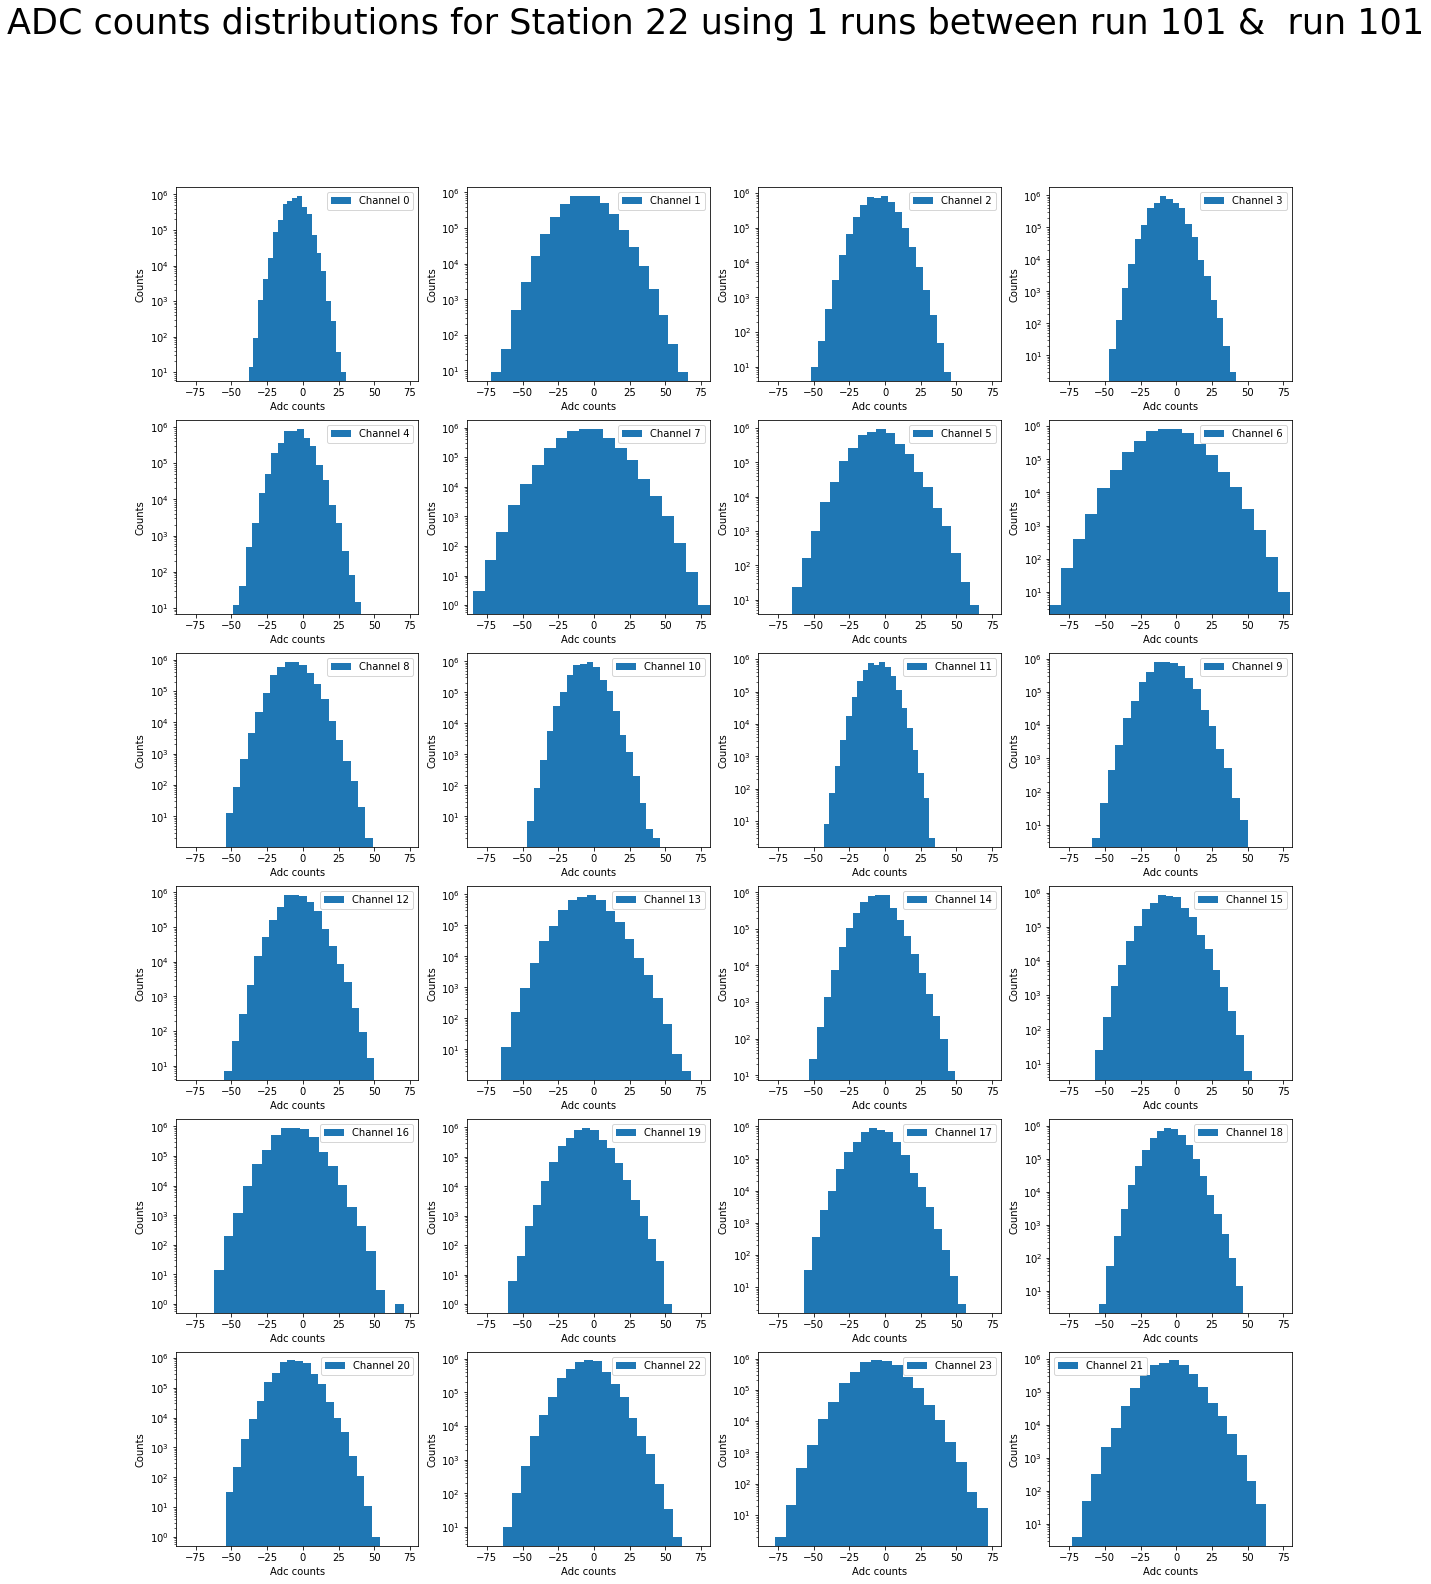

The ADCDist took 1.7777215838432312 minutes of time


In [7]:
t0 = time.time()
#ADCDist(22,range(70,130),NBins=20,WPed=False)
ADCDist(22,[101],NBins=20,WPed=False)
dt=time.time() - t0
print("The ADCDist took %s minutes of time" % (dt/60))

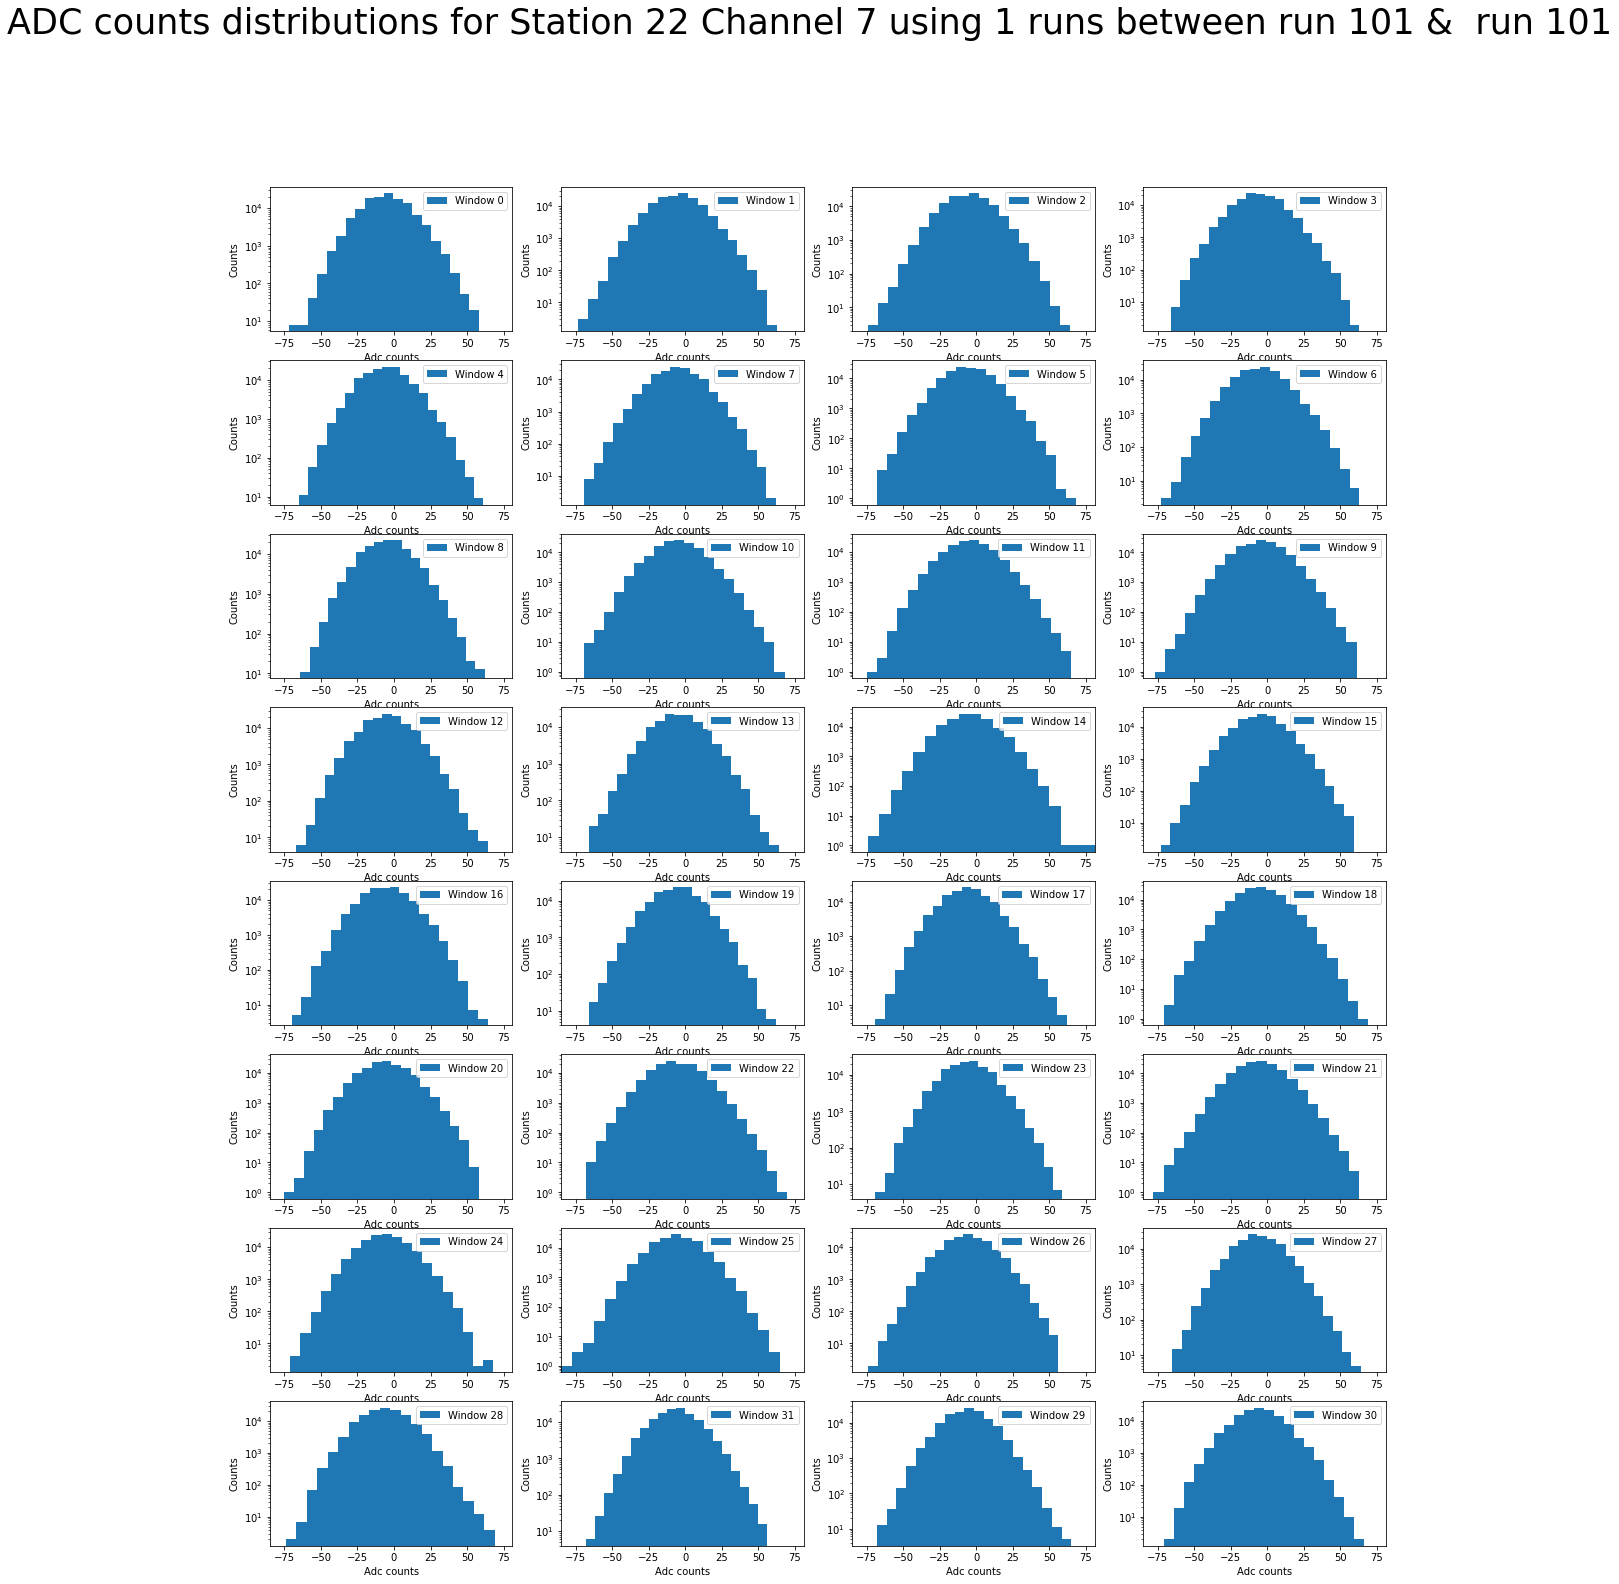

The ADCDistCh took 0.2186135252316793 minutes of time


In [8]:
t0 = time.time()
ADCDistCh(22,7,[101],NBins=20,WPed=False)
dt=time.time() - t0
print("The ADCDistCh took %s minutes of time" % (dt/60))

# Fit data

Look at data from station 22, run 101, channel 7

In [9]:
CombinedFileSt22R101, DAQStatFileSt22R101, HeadersFileSt22R101, PedestalFileSt22R101=FilesStRun(22,101)
RadiantDataSt22R101=CombinedFileSt22R101['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
EventNrsSt22R101=CombinedFileSt22R101['combined']['waveforms']['event_number'].array(library="np")
PedestalDataSt22R101=PedestalFileSt22R101['']['pedestals[24][4096]'].array(library='np')
StartWindowSt22R101 = np.array(CombinedFileSt22R101['combined']['header/trigger_info/trigger_info.radiant_info.start_windows[24][2]'])

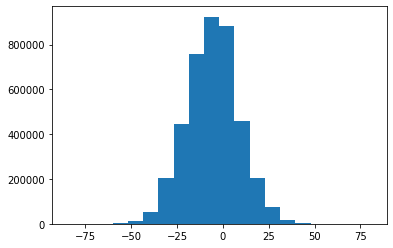

In [10]:
RadiantDataSt22R101AllEvents=np.array([])
for i in range(len(EventNrsSt22R101)):
    RadiantDataSt22R101AllEvents=np.append(RadiantDataSt22R101AllEvents,RadiantDataSt22R101[i][7])
counts, bins, bars = plt.hist(RadiantDataSt22R101AllEvents,bins=20)
#plt.yscale('log')

[8.91799893e-08 1.01070655e-06 8.79909228e-06 7.21763380e-05
 3.74526228e-04 1.58903878e-03 6.14066652e-03 1.33041978e-02
 2.25123587e-02 2.74817055e-02 2.62284294e-02 1.36576478e-02
 6.08044030e-03 2.29495784e-03 5.61893386e-04 1.39655863e-04
 3.00833831e-05 3.83473954e-06 3.86446620e-07 2.97266631e-08]
0.9999999999999994


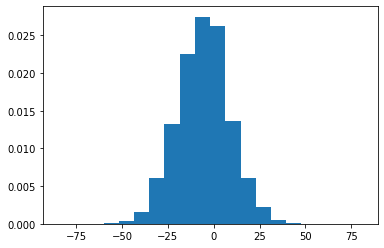

In [11]:
#Amplitudes=np.arange(-75,75,0.1)
#P_AGL=[SASGL(A,-5.5587,-0.5,1.5,10) for A in Amplitudes]

counts2, bins2, bars2=plt.hist(RadiantDataSt22R101AllEvents,bins=20,density=True)
#plt.plot(Amplitudes,P_AGL,'-', label="GL method")
plt.plot()
#plt.yscale('log')
print(counts2)
print(sum(counts2)*(bins2[1]-bins2[0]))

In [12]:
print(counts)
print(bins)
TotCount=np.sum(counts)
print(TotCount)
print(len(RadiantDataSt22R101AllEvents))

[3.00000e+00 3.40000e+01 2.96000e+02 2.42800e+03 1.25990e+04 5.34550e+04
 2.06571e+05 4.47551e+05 7.57312e+05 9.24480e+05 8.82320e+05 4.59441e+05
 2.04545e+05 7.72020e+04 1.89020e+04 4.69800e+03 1.01200e+03 1.29000e+02
 1.30000e+01 1.00000e+00]
[-85.  -76.7 -68.4 -60.1 -51.8 -43.5 -35.2 -26.9 -18.6 -10.3  -2.    6.3
  14.6  22.9  31.2  39.5  47.8  56.1  64.4  72.7  81. ]
4052992.0
4052992


In [13]:
midbins=[(bins[i] + bins[i+1])/2 for i in range(0,len(bins)-1)]
print(midbins)

[-80.85, -72.55000000000001, -64.25, -55.949999999999996, -47.65, -39.349999999999994, -31.049999999999994, -22.749999999999993, -14.449999999999996, -6.149999999999999, 2.1500000000000057, 10.45000000000001, 18.750000000000007, 27.05000000000001, 35.350000000000016, 43.65000000000001, 51.95000000000002, 60.250000000000014, 68.55000000000001, 76.85000000000001]


def SASQuadNorm(A,mu,beta,alpha,sigma):
    QuadNorm=scipy.integrate.quad(SASQuad,-np.inf,np.inf,args=(mu,beta,alpha,sigma))[0]
    return SASQuad(A,mu,beta,alpha,sigma)/QuadNorm

def SASGLNorm(A,mu,beta,alpha,sigma):
    global GLNorm
    return SASGL(A,mu,beta,alpha,sigma)/GLNorm

In [14]:
#SASQuad(A,mu,beta,alpha,sigma)
vSASQuad = np.vectorize(SASQuad, excluded=set([1,2,3,4]))
parametersQ, covariance = curve_fit(vSASQuad, midbins, counts2, p0=[-5.56,0,1.25,14.4])
parametersQ

array([-5.22452425,  0.1623475 ,  1.913073  ,  9.9537826 ])

In [15]:
SASQuad(0,parametersQ[0],parametersQ[1],parametersQ[2],parametersQ[3])

0.026477966711353808

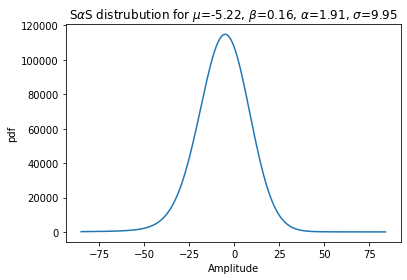

In [16]:
Amplitudes=np.arange(-85,85,1)
P_A=[TotCount*SASQuad(A,parametersQ[0],parametersQ[1],parametersQ[2],parametersQ[3]) for A in Amplitudes]

plt.figure()#figsize=(20,5))
#plt.hist(RadiantDataSt22R101AllEvents,bins=20)
plt.plot(Amplitudes,P_A,'-')#, label="Channel " + str(ChNr))
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title(r"S$\alpha$S distrubution for $\mu$=" + str(np.round(parametersQ[0],2)) + r", $\beta$=" + str(np.round(parametersQ[1],2)) + r", $\alpha$=" + str(np.round(parametersQ[2],2)) + r", $\sigma$=" + str(np.round(parametersQ[3],2)))
#plt.ylim(-50,50)
#plt.xlim(0,np.max(SamplingTimes*(10**9)))
plt.xlabel("Amplitude")
plt.ylabel("pdf")
#plt.yscale('log')
#plt.legend()
plt.show()

In [17]:
mu0=np.average(midbins,weights=counts/TotCount)
sigma0 = np.sqrt(np.average((midbins - mu0)**2, weights=counts/TotCount))
print(r"$\mu_0$=" + str(mu0) + r" and $\sigma_0$=" + str(sigma0))#p0=[mu0,0,1.25,sigma0]
parametersGL, covariance = curve_fit(SASGL, midbins, counts2,p0=[-5.5587,-0.5,1.5,10] , bounds=([min(bins),-1,0,0],[max(bins),1,2,np.inf]), maxfev=5000)
print(parametersGL)

$\mu_0$=-5.558769743438916 and $\sigma_0$=14.375191561258559
[-5.22442712  0.16241404  1.9130305   9.95375413]


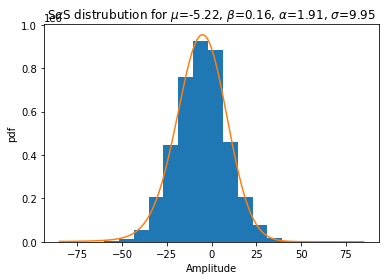

In [18]:
Amplitudes=np.arange(-85,85,0.1)
P_AGL=[TotCount*(bins2[1]-bins2[0])*SASGL(A,parametersGL[0],parametersGL[1],parametersGL[2],parametersGL[3]) for A in Amplitudes]

plt.figure()#figsize=(20,5))
plt.hist(RadiantDataSt22R101AllEvents,bins=20)
plt.plot(Amplitudes,P_AGL,'-')#, label="Channel " + str(ChNr))
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title(r"S$\alpha$S distrubution for $\mu$=" + str(np.round(parametersGL[0],2)) + r", $\beta$=" + str(np.round(parametersGL[1],2)) + r", $\alpha$=" + str(np.round(parametersGL[2],2)) + r", $\sigma$=" + str(np.round(parametersGL[3],2)))
#plt.ylim(-50,50)
#plt.xlim(0,np.max(SamplingTimes*(10**9)))
plt.xlabel("Amplitude")
plt.ylabel("pdf")
#plt.yscale('log')
#plt.legend()
plt.show()

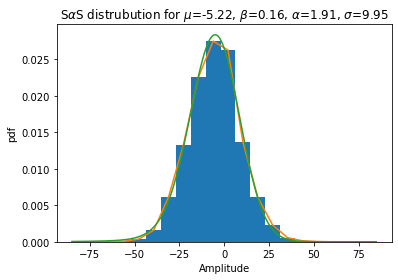

In [19]:
Amplitudes=np.arange(-85,85,0.1)
P_AGL=[SASGL(A,parametersGL[0],parametersGL[1],parametersGL[2],parametersGL[3]) for A in Amplitudes]

plt.figure()#figsize=(20,5))
plt.hist(RadiantDataSt22R101AllEvents,bins=20,density=True)
plt.plot(midbins,counts2)
plt.plot(Amplitudes,P_AGL,'-')#, label="Channel " + str(ChNr))
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title(r"S$\alpha$S distrubution for $\mu$=" + str(np.round(parametersGL[0],2)) + r", $\beta$=" + str(np.round(parametersGL[1],2)) + r", $\alpha$=" + str(np.round(parametersGL[2],2)) + r", $\sigma$=" + str(np.round(parametersGL[3],2)))
#plt.ylim(-50,50)
#plt.xlim(0,np.max(SamplingTimes*(10**9)))
plt.xlabel("Amplitude")
plt.ylabel("pdf")
#plt.yscale('log')
#plt.legend()
plt.show()

# Extract FWHM and associated voltage

In [20]:
Max=max(P_AGL)
ZeroCross=[P-Max/2 for P in P_AGL]
sgn=np.sign(ZeroCross[0])
ZCs=[]
for ZC in ZeroCross:
    if np.sign(ZC)!=sgn:
        ZCs.append(ZeroCross.index(ZC))
        sgn=np.sign(ZC)

if len(ZCs)==2:
    LeftZero,RightZero=Amplitudes[ZCs[0]],Amplitudes[ZCs[1]]
else:
    print("Error, more than two values at half max detected")
    
print("Half Max occurs at " + str(LeftZero) + " and " + str(RightZero))
print("Hereby yielding FWHM=" + str(RightZero-LeftZero))

Half Max occurs at -21.600000000003604 and 10.999999999994543
Hereby yielding FWHM=32.59999999999815


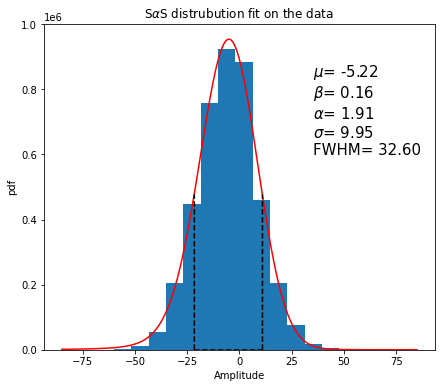

In [21]:
Amplitudes=np.arange(-85,85,0.1)
P_AGL=[TotCount*(bins2[1]-bins2[0])*SASGL(A,parametersGL[0],parametersGL[1],parametersGL[2],parametersGL[3]) for A in Amplitudes]
Vertical=np.arange(0,max(P_AGL)/2,0.1)
Horizontal=np.arange(LeftZero,RightZero,0.1)

plt.figure(figsize=(7,6))
plt.hist(RadiantDataSt22R101AllEvents,bins=20)
plt.plot(Amplitudes,P_AGL,'-',color='red')#, label="Channel " + str(ChNr))
plt.plot(LeftZero*np.ones(len(Vertical)),Vertical,'--',color='black')#, label="Channel " + str(ChNr))
plt.plot(RightZero*np.ones(len(Vertical)),Vertical,'--',color='black')#, label="Channel " + str(ChNr))
plt.plot(Horizontal,(Max/2)*np.ones(len(Horizontal)),'--',color='black')#, label="Channel " + str(ChNr))
plt.text(35, 0.6*1e6, r"$\mu$= %1.2f"%(parametersGL[0]) + "\n" + r"$\beta$= %1.2f"%(parametersGL[1]) + "\n" + r"$\alpha$= %1.2f"%(parametersGL[2]) + "\n" +  r"$\sigma$= %1.2f"%(parametersGL[3]) + "\n" + r"FWHM= %1.2f"%(RightZero-LeftZero), fontsize=15)#'min=%f \n  max=%f'%(min(Masses),max(Masses))) #r'$\sigma=%.2f$' % (sigma, ) \n
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title(r"S$\alpha$S distrubution fit on the data") #for $\mu$=" + str(np.round(parametersGL[0],2)) + r", $\beta$=" + str(np.round(parametersGL[1],2)) + r", $\alpha$=" + str(np.round(parametersGL[2],2)) + r", $\sigma$=" + str(np.round(parametersGL[3],2))
#plt.ylim(-50,50)
#plt.xlim(0,np.max(SamplingTimes*(10**9)))
plt.xlabel("Amplitude")
plt.ylabel("pdf")
#plt.yscale('log')
#plt.legend()
plt.show()

In [22]:
p,c=SASFit(RadiantDataSt22R101AllEvents,[-5.5587,-0.5,1.5,10],20)
print(p)

[-5.22442712  0.16241404  1.9130305   9.95375413]


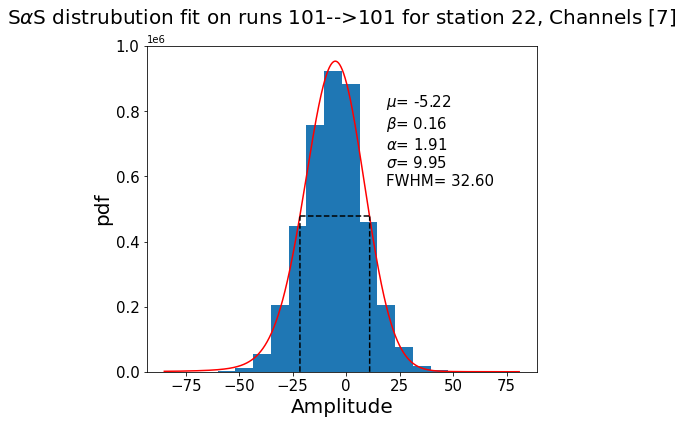

In [18]:
Param,FWHM=SASFitRuns(22,[101],ChNrs=[7],Plot=True)

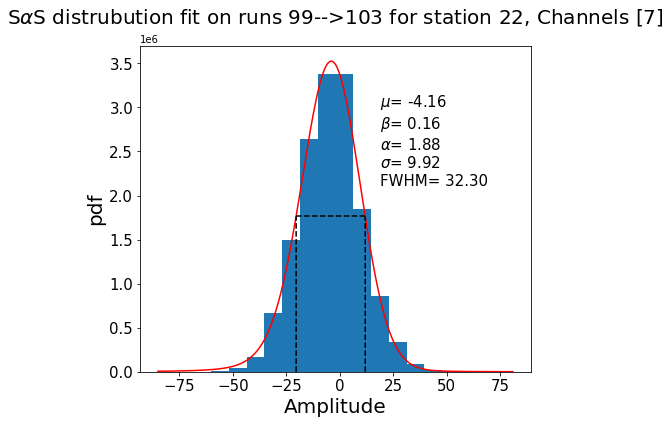

In [21]:
Param,FWHM=SASFitRuns(22,[99,100,101,102,103],ChNrs=[7],Plot=True)

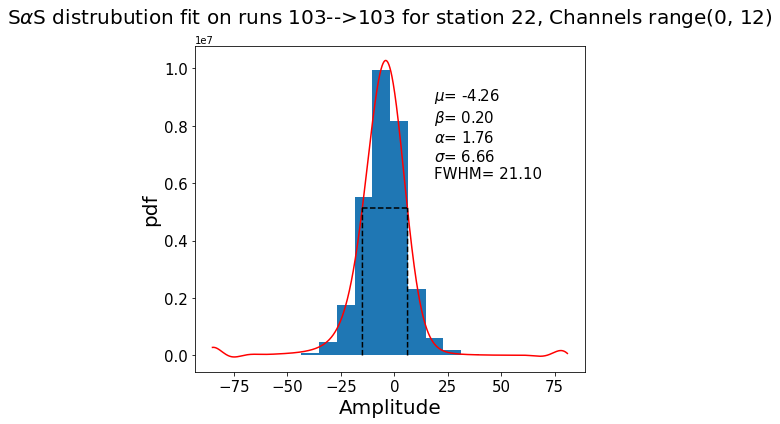

In [19]:
param2,FWHM2=SASFitRuns(22,[103],ChNrs=range(12),Plot=True)

In [1]:
%%capture out
%run ./FunctionsRevised.ipynb

101
Reading in complete
Fits completed


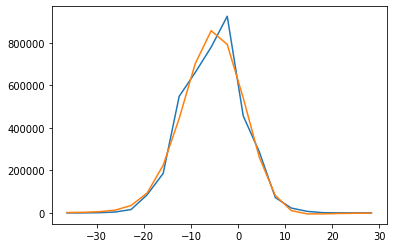

Power_divergenceResult(statistic=75152.11174317416, pvalue=0.0)
ChiSq: 7820468836.484357 with dof: 4052987.999999999
ChiSq: 1981016646790315.8 with dof: 16


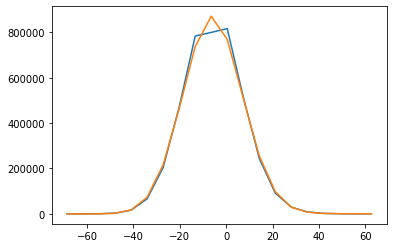

Power_divergenceResult(statistic=12117.180637091022, pvalue=0.0)
ChiSq: 1893737597.4989598 with dof: 4052988.000000003
ChiSq: 479705984863257.44 with dof: 16


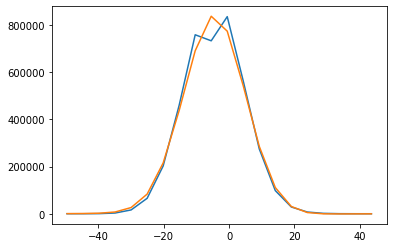

Power_divergenceResult(statistic=28048.549125876347, pvalue=0.0)
ChiSq: 3750713196.960687 with dof: 4052987.999999998
ChiSq: 950099723670205.9 with dof: 16


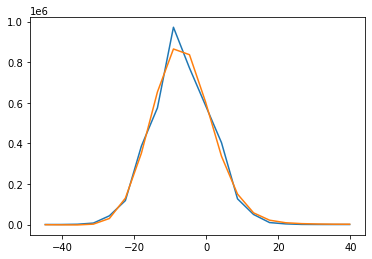

Power_divergenceResult(statistic=82398.70265794115, pvalue=0.0)
ChiSq: 5064680696.876706 with dof: 4052988.000000002
ChiSq: 1282943130517058.5 with dof: 16


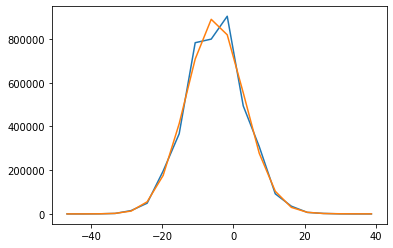

Power_divergenceResult(statistic=47512.29704172792, pvalue=0.0)
ChiSq: 5022897741.80606 with dof: 4052988.0
ChiSq: 1272359017047941.2 with dof: 16


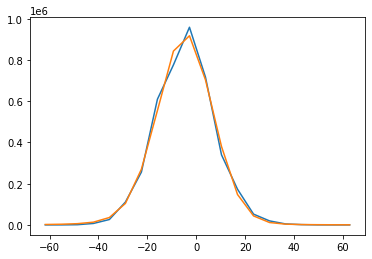

Power_divergenceResult(statistic=46452.17967432697, pvalue=0.0)
ChiSq: 1927197056.4270678 with dof: 4052987.999999999
ChiSq: 488181658958389.2 with dof: 16


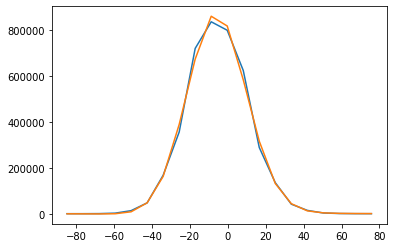

Power_divergenceResult(statistic=-11997.58274385168, pvalue=1.0)
ChiSq: 980183900.081585 with dof: 4052988.000000002
ChiSq: 248292099051491.56 with dof: 16


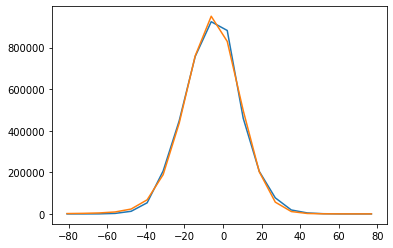

Power_divergenceResult(statistic=46982.34218884001, pvalue=0.0)
ChiSq: 961077737.9589087 with dof: 4052987.9999999977
ChiSq: 243452283688412.44 with dof: 16


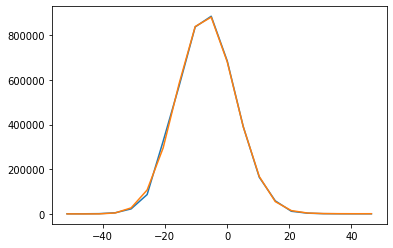

Power_divergenceResult(statistic=5893.201517433876, pvalue=0.0)
ChiSq: 105006072.12704596 with dof: 4052987.9999999986
ChiSq: 26599271891128.227 with dof: 16


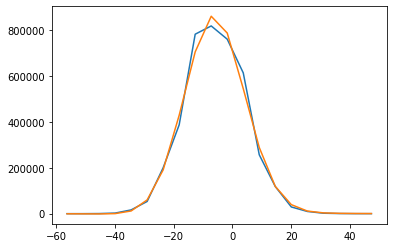

Power_divergenceResult(statistic=59243.87848928874, pvalue=0.0)
ChiSq: 2598915276.016742 with dof: 4052988.0000000014
ChiSq: 658335776669534.2 with dof: 16


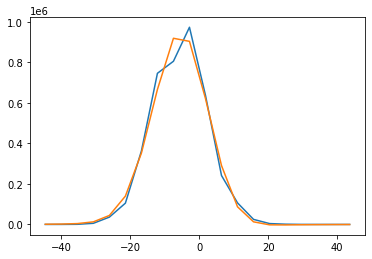

Power_divergenceResult(statistic=44136.33678456827, pvalue=0.0)
ChiSq: 5132076440.304455 with dof: 4052987.9999999986
ChiSq: 1300015264227291.5 with dof: 16


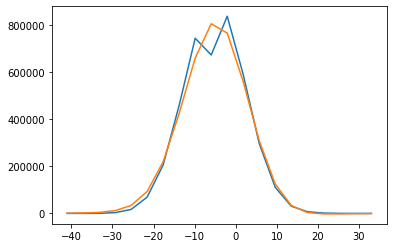

Power_divergenceResult(statistic=66964.10405053996, pvalue=0.0)
ChiSq: 5639394524.499799 with dof: 4052987.999999999
ChiSq: 1428524895941461.5 with dof: 16


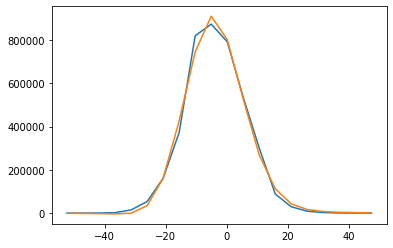

Power_divergenceResult(statistic=-945402.6572735135, pvalue=1.0)
ChiSq: 1791676942.300882 with dof: 4052988.0
ChiSq: 453852821688885.5 with dof: 16


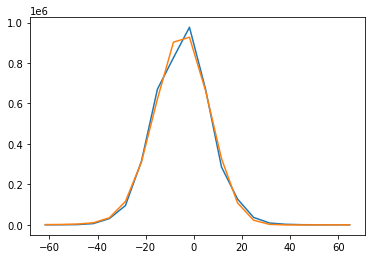

Power_divergenceResult(statistic=42889.52286549923, pvalue=0.0)
ChiSq: 2338281490.733241 with dof: 4052987.999999999
ChiSq: 592314176410246.0 with dof: 16


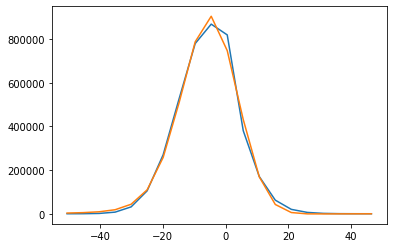

Power_divergenceResult(statistic=2623.9294254036, pvalue=0.0)
ChiSq: 1647469192.1413724 with dof: 4052988.0000000014
ChiSq: 417323304132417.44 with dof: 16


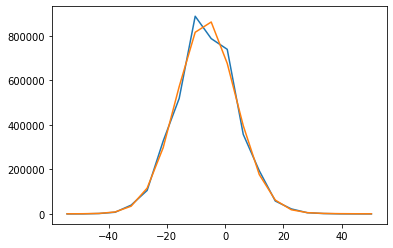

Power_divergenceResult(statistic=37774.32810561283, pvalue=0.0)
ChiSq: 3527125326.506649 with dof: 4052988.0
ChiSq: 893462288926720.6 with dof: 16


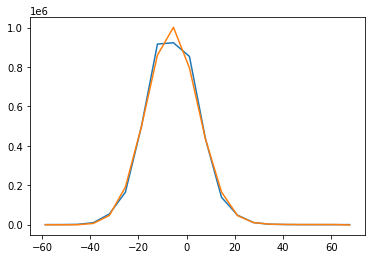

Power_divergenceResult(statistic=18054.84121871031, pvalue=0.0)
ChiSq: 2907676990.252905 with dof: 4052987.999999999
ChiSq: 736548746835696.1 with dof: 16


/tmp/ipykernel_96/920813076.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  Var=[1/N_obs[i] for i in range(len(N_obs))]


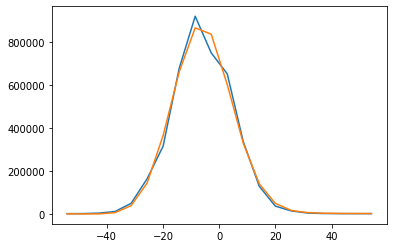

Power_divergenceResult(statistic=29524.996926477645, pvalue=0.0)
ChiSq: 2725104410.774162 with dof: 4052988.0000000014
ChiSq: 690300967225922.0 with dof: 16


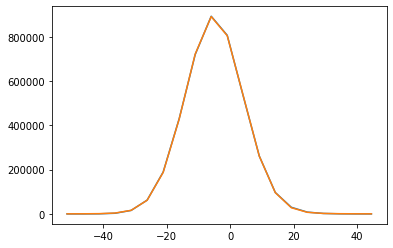

Power_divergenceResult(statistic=2658.5000721940637, pvalue=0.0)
ChiSq: 2431063.1740639955 with dof: 4052987.9999999986
ChiSq: 615816866982.7051 with dof: 16


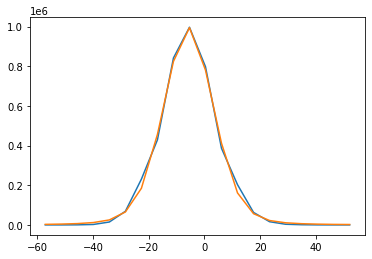

Power_divergenceResult(statistic=70632.7965592139, pvalue=0.0)
ChiSq: 466238845.22441334 with dof: 4052988.0
ChiSq: 118103777801775.28 with dof: 16


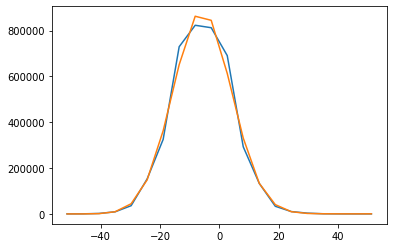

Power_divergenceResult(statistic=33959.033946195515, pvalue=0.0)
ChiSq: 2876079658.460562 with dof: 4052987.999999998
ChiSq: 728544771424047.0 with dof: 16


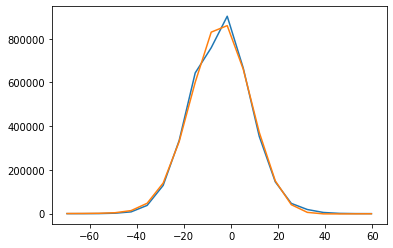

Power_divergenceResult(statistic=4616.757875313068, pvalue=0.0)
ChiSq: 1695775524.7506404 with dof: 4052987.999999999
ChiSq: 429559865781752.94 with dof: 16


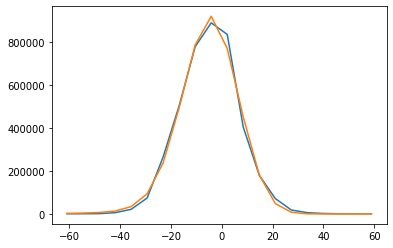

Power_divergenceResult(statistic=-63389.84756353786, pvalue=1.0)
ChiSq: 1413631246.2884898 with dof: 4052987.9999999986
ChiSq: 358089404852018.25 with dof: 16


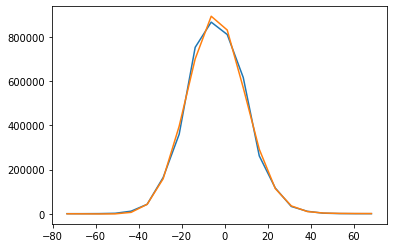

Power_divergenceResult(statistic=11688.900259908565, pvalue=0.0)
ChiSq: 1250087272.954655 with dof: 4052988.000000001
ChiSq: 316661794764871.4 with dof: 16
FWHM computed


In [2]:
ChParams, ChCov, ChChiSq, ChFWHM= SASFitStation(22,[101],NBins=20, Plot=False)

In [3]:
ChCov[0]

array([[ 0.12927696,  0.00658501, -0.00223721, -0.0059478 ],
       [ 0.00658501,  0.00268146, -0.00835235,  0.00154866],
       [-0.00223721, -0.00835235,  0.05085067, -0.00057155],
       [-0.0059478 ,  0.00154866, -0.00057155,  0.03136698]])

In [30]:
print(ChChiSq)

[7820468836.484357, 1893737597.4989598, 3750713196.960687, 5064680696.876706, 5022897741.80606, 1927197056.4270678, 980183900.081585, 961077737.9589087, 105006072.12704596, 2598915276.016742, 5132076440.304455, 5639394524.499799, 1791676942.300882, 2338281490.733241, 1647469192.1413724, 3527125326.506649, 2907676990.252905, 2725104410.774162, 2431063.1740639955, 466238845.22441334, 2876079658.460562, 1695775524.7506404, 1413631246.2884898, 1250087272.954655]


In [10]:
from scipy.stats import chisquare
ChCountstest=np.array([3.28975072e-07, 2.44381482e-06, 1.45218996e-05, 9.87395179e-05,
 6.97427152e-04, 2.50970382e-03, 7.57512099e-03, 1.75182515e-02,
 3.85114668e-02, 4.10259642e-02, 3.72080205e-02, 2.51346824e-02,
 1.41072030e-02, 4.14226612e-03, 1.36905326e-03, 4.08963010e-04,
 1.25104520e-04, 2.17123547e-05, 4.41766525e-06, 7.98939460e-07])
SASGLtest=np.array([-4.4377483857751736e-05, -6.782607358174042e-05, -0.00011341433846897867, -0.00017622031039351858, -1.0847323381737885e-05, 0.001620677278386781, 0.007584446457959168, 0.02003747472864898, 0.03502288169357652, 0.04274631478433652, 0.03767549291548292, 0.02474435759086216, 0.012592191979942135, 0.005263096193845672, 0.0019829916064159746, 0.0007680866677720093, 0.000344875220822162, 0.0001850458926230899, 0.00011087209440686762, 8.017237077508814e-05])
MidBinstest=np.array([-52.375, -47.125, -41.875, -36.625, -31.375, -26.125, -20.875, -15.625, -10.375, -5.125, 0.125, 5.375, 10.625, 15.875, 21.125, 26.375, 31.625, 36.875, 42.125, 47.375])

#SASGLtest=[SASGLtest[i] if SASGLtest[i]>=0 else 0 for i in range(len(SASGLtest))]
print("Sums:")
print(np.sum(ChCountstest))
print(np.sum(SASGLtest))
print("NormalisedDistr.")
ChCountstestNorm=ChCountstest/np.sum(ChCountstest)
print(ChCountstestNorm)
SASGLtestNorm=SASGLtest/np.sum(SASGLtest)
print(SASGLtestNorm)
print("ChiSq:")
print(chisquare(ChCountstest/np.sum(ChCountstest),SASGLtest/np.sum(SASGLtest)))
print("ChiSqSelf:")
print(((ChCountstestNorm-SASGLtestNorm)**2)/SASGLtestNorm)
print(np.sum(((ChCountstestNorm-SASGLtestNorm)**2)/SASGLtestNorm))
print("OtherChiSqDef:")
VarTest=np.sum([SASGLtestNorm[i]*(MidBinstest[i]**2) for i in range(len(MidBinstest))])-np.sum([SASGLtestNorm[i]*MidBinstest[i] for i in range(len(MidBinstest))])**2
OtherChiSq=np.sum(((ChCountstestNorm-SASGLtestNorm)**2))/VarTest
print(OtherChiSq)

Sums:
0.19047619043880204
0.1903462919461723
NormalisedDistr.
[1.72711913e-06 1.28300278e-05 7.62399729e-05 5.18382469e-04
 3.66149255e-03 1.31759451e-02 3.97693852e-02 9.19708204e-02
 2.02185201e-01 2.15386312e-01 1.95342108e-01 1.31957083e-01
 7.40628158e-02 2.17468971e-02 7.18752962e-03 2.14705580e-03
 6.56798730e-04 1.13989862e-04 2.31927426e-05 4.19443217e-06]
[-2.33140785e-04 -3.56329892e-04 -5.95831615e-04 -9.25787987e-04
 -5.69873112e-05  8.51436223e-03  3.98455172e-02  1.05268532e-01
  1.83995608e-01  2.24571303e-01  1.97931320e-01  1.29996531e-01
  6.61541228e-02  2.76501115e-02  1.04178105e-02  4.03520688e-03
  1.81183052e-03  9.72153913e-04  5.82475725e-04  4.21192186e-04]
ChiSq:
Power_divergenceResult(statistic=-0.23326043034286964, pvalue=1.0)
ChiSqSelf:
[-2.36607817e-04 -3.82451906e-04 -7.58066890e-04 -2.25281418e-03
 -2.42634582e-01  2.55219991e-03  1.45463973e-07  1.67979102e-03
  1.79820210e-03  3.75667127e-04  3.38704509e-05  2.95682023e-05
  9.45480358e-04  1.260318

In [3]:
%%capture out
%run ./FunctionsRevised.ipynb

101
Reading in complete
Fits completed


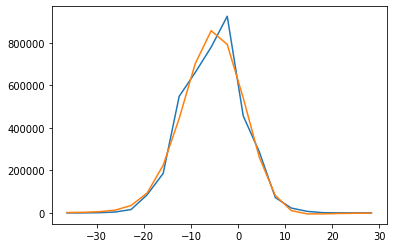

Power_divergenceResult(statistic=75152.11174317416, pvalue=0.0)
ChiSq: 7820468836.484357 with dof: 4052987.999999999
ChiSq: 1981016646790315.8 with dof: 16


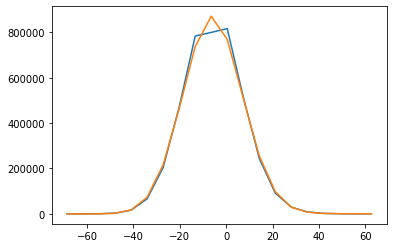

Power_divergenceResult(statistic=12117.180637091022, pvalue=0.0)
ChiSq: 1893737597.4989598 with dof: 4052988.000000003
ChiSq: 479705984863257.44 with dof: 16


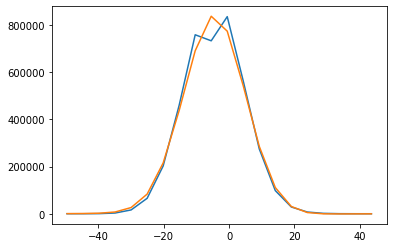

Power_divergenceResult(statistic=28048.549125876347, pvalue=0.0)
ChiSq: 3750713196.960687 with dof: 4052987.999999998
ChiSq: 950099723670205.9 with dof: 16


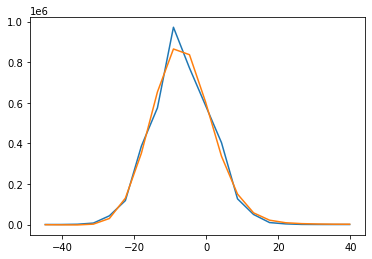

Power_divergenceResult(statistic=82398.70265794115, pvalue=0.0)
ChiSq: 5064680696.876706 with dof: 4052988.000000002
ChiSq: 1282943130517058.5 with dof: 16


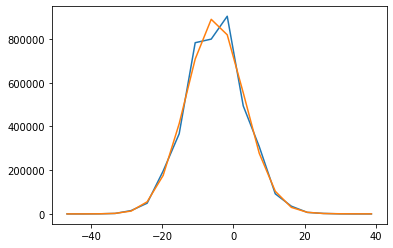

Power_divergenceResult(statistic=47512.29704172792, pvalue=0.0)
ChiSq: 5022897741.80606 with dof: 4052988.0
ChiSq: 1272359017047941.2 with dof: 16


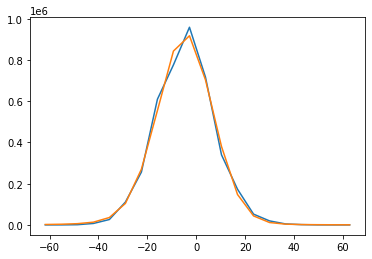

Power_divergenceResult(statistic=46452.17967432697, pvalue=0.0)
ChiSq: 1927197056.4270678 with dof: 4052987.999999999
ChiSq: 488181658958389.2 with dof: 16


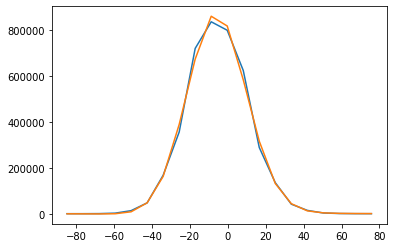

Power_divergenceResult(statistic=-11997.58274385168, pvalue=1.0)
ChiSq: 980183900.081585 with dof: 4052988.000000002
ChiSq: 248292099051491.56 with dof: 16


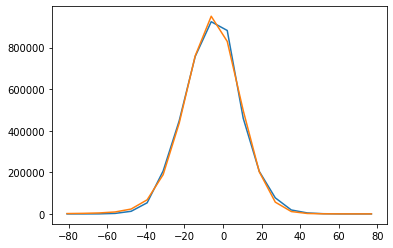

Power_divergenceResult(statistic=46982.34218884001, pvalue=0.0)
ChiSq: 961077737.9589087 with dof: 4052987.9999999977
ChiSq: 243452283688412.44 with dof: 16


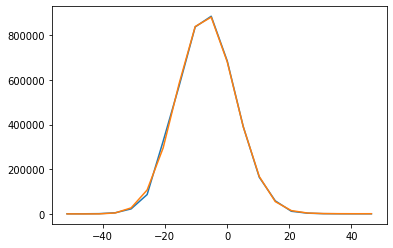

Power_divergenceResult(statistic=5893.201517433876, pvalue=0.0)
ChiSq: 105006072.12704596 with dof: 4052987.9999999986
ChiSq: 26599271891128.227 with dof: 16


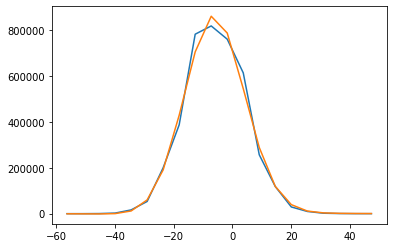

Power_divergenceResult(statistic=59243.87848928874, pvalue=0.0)
ChiSq: 2598915276.016742 with dof: 4052988.0000000014
ChiSq: 658335776669534.2 with dof: 16


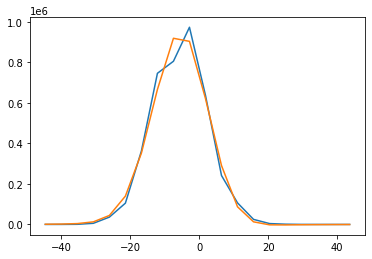

Power_divergenceResult(statistic=44136.33678456827, pvalue=0.0)
ChiSq: 5132076440.304455 with dof: 4052987.9999999986
ChiSq: 1300015264227291.5 with dof: 16


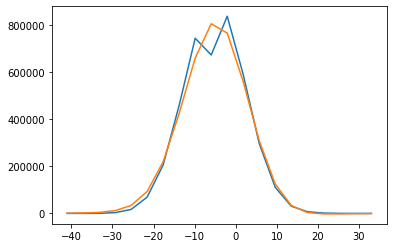

Power_divergenceResult(statistic=66964.10405053996, pvalue=0.0)
ChiSq: 5639394524.499799 with dof: 4052987.999999999
ChiSq: 1428524895941461.5 with dof: 16


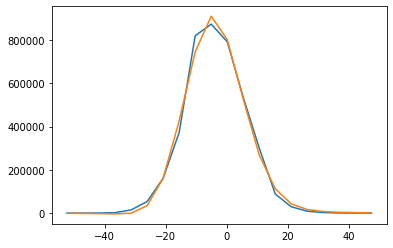

Power_divergenceResult(statistic=-945402.6572735135, pvalue=1.0)
ChiSq: 1791676942.300882 with dof: 4052988.0
ChiSq: 453852821688885.5 with dof: 16


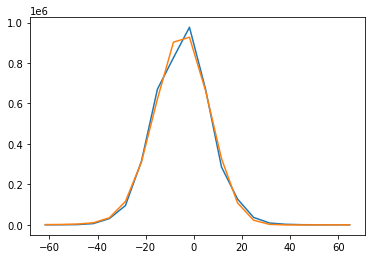

Power_divergenceResult(statistic=42889.52286549923, pvalue=0.0)
ChiSq: 2338281490.733241 with dof: 4052987.999999999
ChiSq: 592314176410246.0 with dof: 16


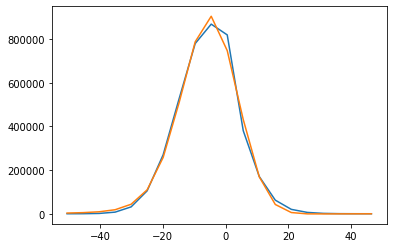

Power_divergenceResult(statistic=2623.9294254036, pvalue=0.0)
ChiSq: 1647469192.1413724 with dof: 4052988.0000000014
ChiSq: 417323304132417.44 with dof: 16


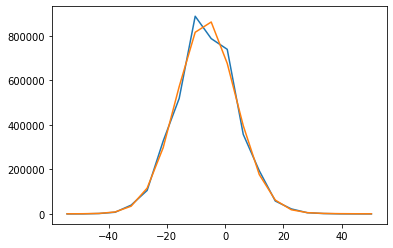

Power_divergenceResult(statistic=37774.32810561283, pvalue=0.0)
ChiSq: 3527125326.506649 with dof: 4052988.0
ChiSq: 893462288926720.6 with dof: 16


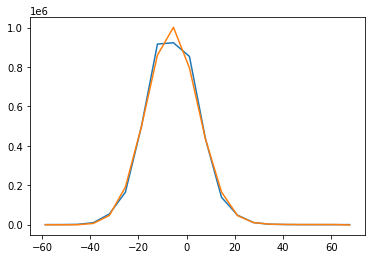

Power_divergenceResult(statistic=18054.84121871031, pvalue=0.0)
ChiSq: 2907676990.252905 with dof: 4052987.999999999
ChiSq: 736548746835696.1 with dof: 16


/tmp/ipykernel_281/920813076.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  Var=[1/N_obs[i] for i in range(len(N_obs))]


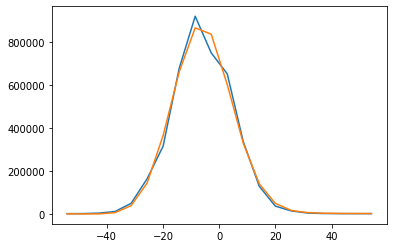

Power_divergenceResult(statistic=29524.996926477645, pvalue=0.0)
ChiSq: 2725104410.774162 with dof: 4052988.0000000014
ChiSq: 690300967225922.0 with dof: 16


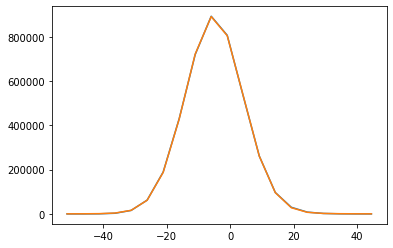

Power_divergenceResult(statistic=2658.5000721940637, pvalue=0.0)
ChiSq: 2431063.1740639955 with dof: 4052987.9999999986
ChiSq: 615816866982.7051 with dof: 16


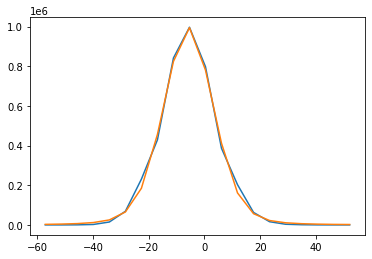

Power_divergenceResult(statistic=70632.7965592139, pvalue=0.0)
ChiSq: 466238845.22441334 with dof: 4052988.0
ChiSq: 118103777801775.28 with dof: 16


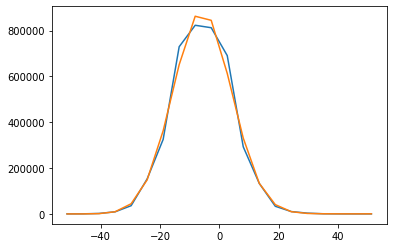

Power_divergenceResult(statistic=33959.033946195515, pvalue=0.0)
ChiSq: 2876079658.460562 with dof: 4052987.999999998
ChiSq: 728544771424047.0 with dof: 16


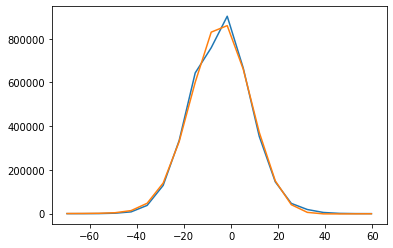

Power_divergenceResult(statistic=4616.757875313068, pvalue=0.0)
ChiSq: 1695775524.7506404 with dof: 4052987.999999999
ChiSq: 429559865781752.94 with dof: 16


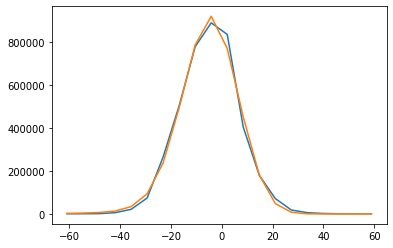

Power_divergenceResult(statistic=-63389.84756353786, pvalue=1.0)
ChiSq: 1413631246.2884898 with dof: 4052987.9999999986
ChiSq: 358089404852018.25 with dof: 16


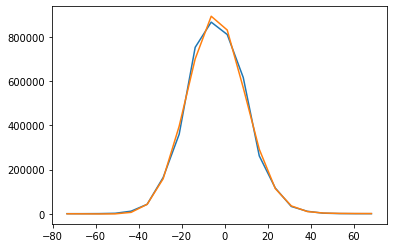

Power_divergenceResult(statistic=11688.900259908565, pvalue=0.0)
ChiSq: 1250087272.954655 with dof: 4052988.000000001
ChiSq: 316661794764871.4 with dof: 16
FWHM computed


In [ ]:
ChParamstest, ChFWHMtest, ChFWHMtest= SASFitStation(22,[101],NBins=20, Plot=True)

In [4]:
for ChNr in range(24):
    print(ChParams[ChNr],ChFWHM[ChNr])

[-5.02691492  0.03306829  2.          4.49152467] 15.000000000000213
[-5.92526994 -0.04194721  1.99999988  9.04933032] 30.09999999999829
[-4.45255788  0.03961067  2.          6.64195243] 22.100000000000314
[-7.32201528 -0.08866701  1.95638132  5.74284141] 19.00000000000027
[-5.19064127 -0.00849574  1.98092833  5.73531013] 19.00000000000027
[-4.52785932  0.07488891  1.89396021  8.08213829] 26.299999999998505
[-5.88598915 -0.10242043  1.99999196 11.04354461] 36.79999999999791
[-5.22443812  0.16240755  1.91303555  9.95375934] 32.59999999999815
[-6.80195838 -0.02982147  1.99999962  6.55350004] 21.80000000000031
[-6.14290607 -0.05902266  2.          7.19810656] 24.00000000000034
[-5.44485236  0.05547112  2.          5.57648682] 18.600000000000264
[-4.84681144  0.05237231  2.          5.45577297] 18.20000000000026
[-4.4364126  -0.15070562  1.95957956  6.57691232] 21.80000000000031
[-4.71894078  0.08216526  1.97535849  7.93987437] 26.299999999998505
[-5.06437219  0.14658083  1.90501708  6.434

In [5]:
[ChParams[P][0] for P in np.arange(24)]

[-5.026914921637005,
 -5.925269935733661,
 -4.452557879901635,
 -7.3220152848145785,
 -5.190641270441908,
 -4.527859324744304,
 -5.88598914563302,
 -5.224438123841312,
 -6.801958375872007,
 -6.142906065325529,
 -5.4448523628858805,
 -4.846811443332358,
 -4.4364126025069295,
 -4.718940775137124,
 -5.064372190440856,
 -6.469445984932829,
 -6.132805697938708,
 -6.285017979516321,
 -5.139074578761155,
 -5.743630625448921,
 -5.761151312662167,
 -4.265260321651493,
 -4.441883217962943,
 -4.1563393849349115]

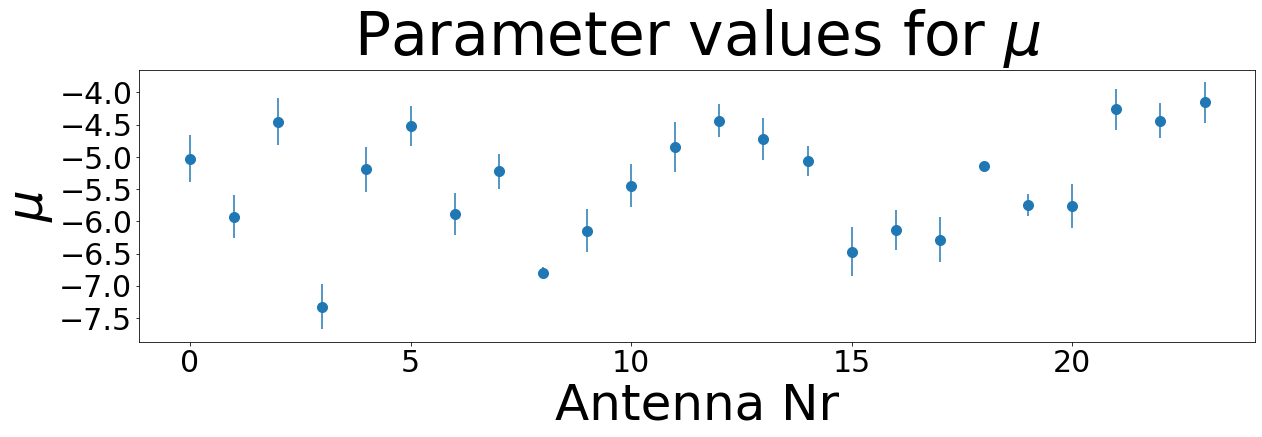

In [7]:
plt.figure(figsize=(20,5))
#plt.plot(np.arange(24),[ChParams[P][0] for P in np.arange(24)],'.', markersize=20)
plt.errorbar(np.arange(24),[ChParams[P][0] for P in np.arange(24)],fmt='.', yerr=[np.sqrt(ChCov[ChNr][0][0]) for ChNr in range(24)], markersize=20)
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title(r"Parameter values for $\mu$",fontsize=60)
#plt.ylim(-50,50)
plt.xlabel("Antenna Nr",fontsize=50)
plt.ylabel(r"$\mu$",fontsize=50)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
#plt.legend()
plt.show()

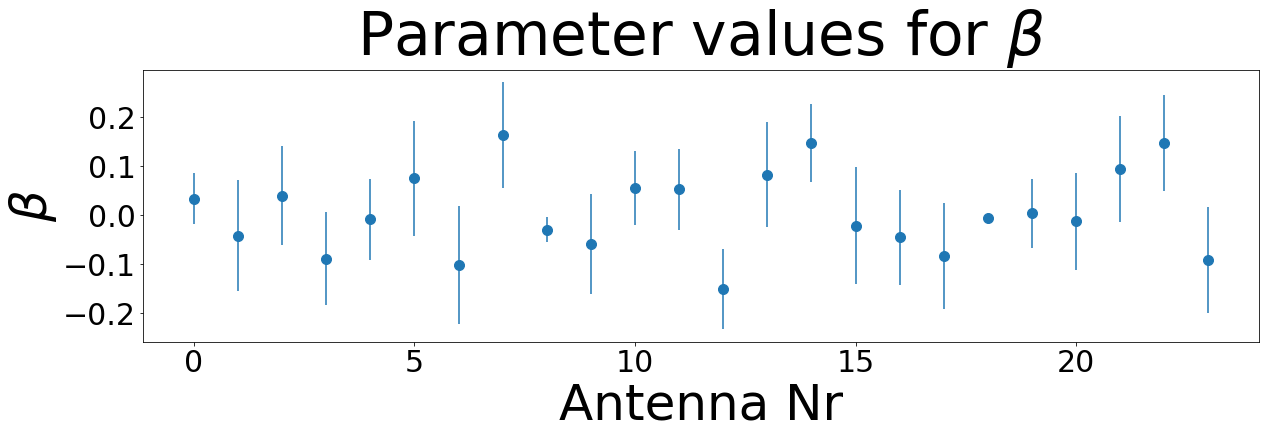

In [9]:
plt.figure(figsize=(20,5))
#plt.plot(np.arange(24),[ChParams[P][1] for P in np.arange(24)],'.', markersize=20)
plt.errorbar(np.arange(24),[ChParams[P][1] for P in np.arange(24)],fmt='.', yerr=[np.sqrt(ChCov[ChNr][1][1]) for ChNr in range(24)], markersize=20)
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title(r"Parameter values for $\beta$",fontsize=60)
#plt.ylim(-50,50)
plt.xlabel("Antenna Nr",fontsize=50)
plt.ylabel(r"$\beta$",fontsize=50)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
#plt.legend()
plt.show()

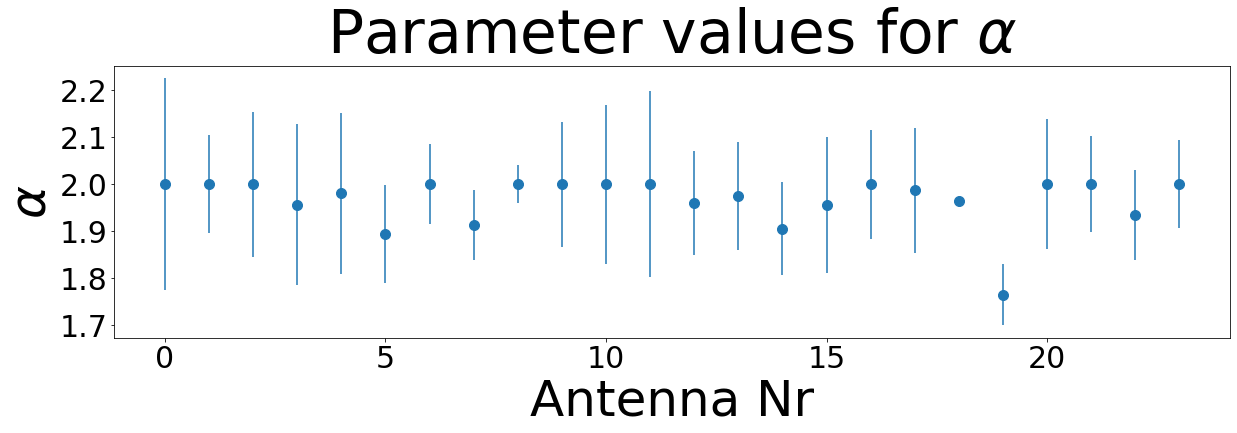

In [11]:
plt.figure(figsize=(20,5))
#plt.plot(np.arange(24),[ChParams[P][2] for P in np.arange(24)],'.', markersize=20)
plt.errorbar(np.arange(24),[ChParams[P][2] for P in np.arange(24)],fmt='.', yerr=[np.sqrt(ChCov[ChNr][2][2]) for ChNr in range(24)], markersize=20)
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title(r"Parameter values for $\alpha$",fontsize=60)
#plt.ylim(-50,50)
plt.xlabel("Antenna Nr",fontsize=50)
plt.ylabel(r"$\alpha$",fontsize=50)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
#plt.legend()
plt.show()

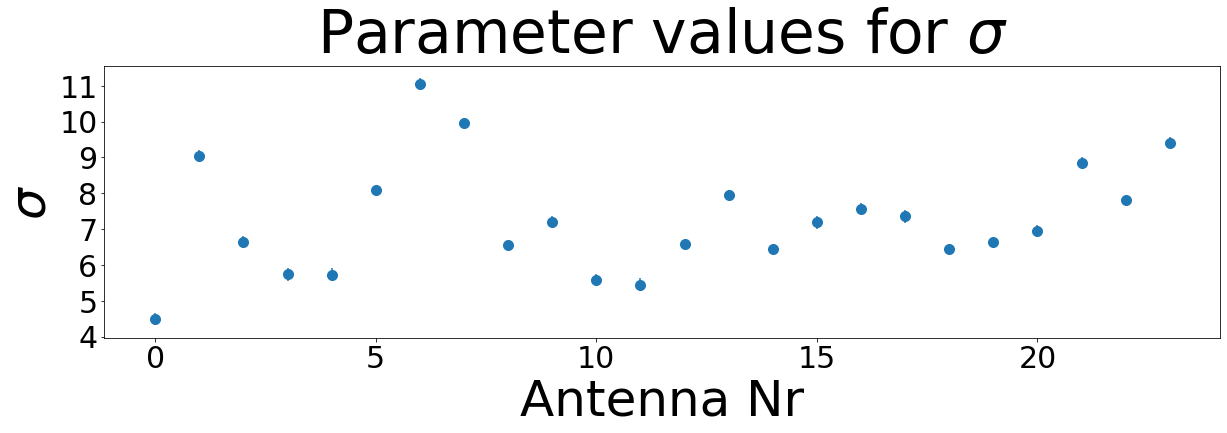

In [12]:
plt.figure(figsize=(20,5))
#plt.plot(np.arange(24),[ChParams[P][3] for P in np.arange(24)],'.', markersize=20)
plt.errorbar(np.arange(24),[ChParams[P][3] for P in np.arange(24)],fmt='.', yerr=[np.sqrt(ChCov[ChNr][3][3]) for ChNr in range(24)], markersize=20)
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title(r"Parameter values for $\sigma$",fontsize=60)
#plt.ylim(-50,50)
plt.xlabel("Antenna Nr",fontsize=50)
plt.ylabel(r"$\sigma$",fontsize=50)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
#plt.legend()
plt.show()

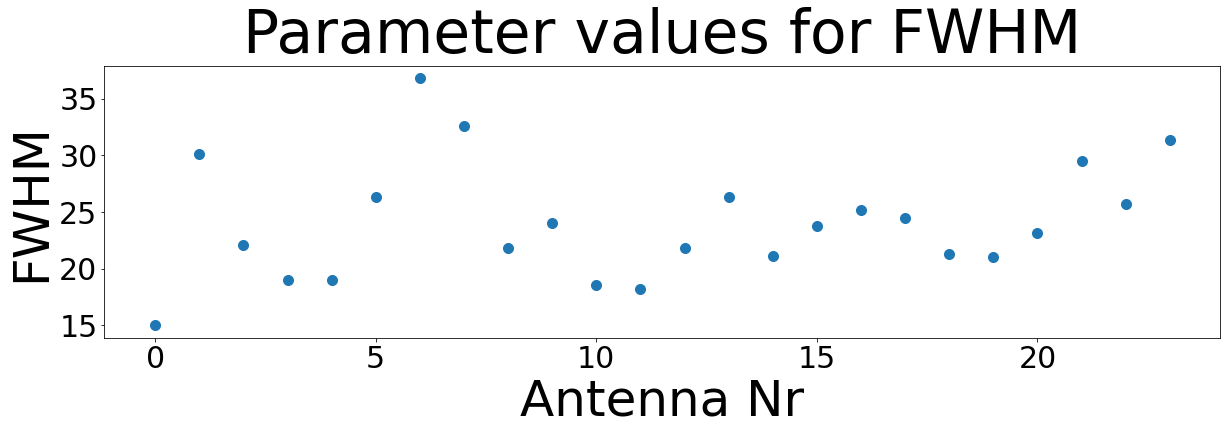

In [14]:
plt.figure(figsize=(20,5))
plt.plot(np.arange(24),ChFWHM,'.', markersize=20)
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title(r"Parameter values for FWHM",fontsize=60)
#plt.ylim(-50,50)
plt.xlabel("Antenna Nr",fontsize=50)
plt.ylabel("FWHM",fontsize=50)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
#plt.legend()
plt.show()

plt.figure(figsize=(20,5))
plt.plot(np.arange(24),ChChiSq,'.', markersize=20)
#plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
plt.title(r"Parameter values for $\chi^2$",fontsize=60)
#plt.ylim(-50,50)
plt.xlabel("Antenna Nr",fontsize=50)
plt.ylabel(r"$\chi^2$",fontsize=50)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.gca().yaxis.get_offset_text().set_fontsize(24)
#plt.legend()
plt.show()

print(ChChiSq)